#  TP 3: 

### 14 avril 2024

### Par Samuel Fortin, Philippe Truchon et Benjamin Trudel

## TP3.1 Mécanique céleste - la Terre

### a)

Utilisez la m´ethode de Verlet pour calculer l’orbite de la Terre autour du soleil, consid´erant
que le mouvement est d´ecrit par

$\frac{d^2r}{dt^2} = -GM \frac{r}{r^3}$

et sachant que la distance du périhélie est de 1.4710×1011 m et que la vitesse tangentielle
à cette position est de 3.0287 × 104 m/s (utilisez le module astropy pour les autres
constantes nécessaires). Utilisez un incrément temporel h = 1 heure. Représentez graphiquement
plusieurs orbites, qui devraient appaître légèrement non-circulaires.

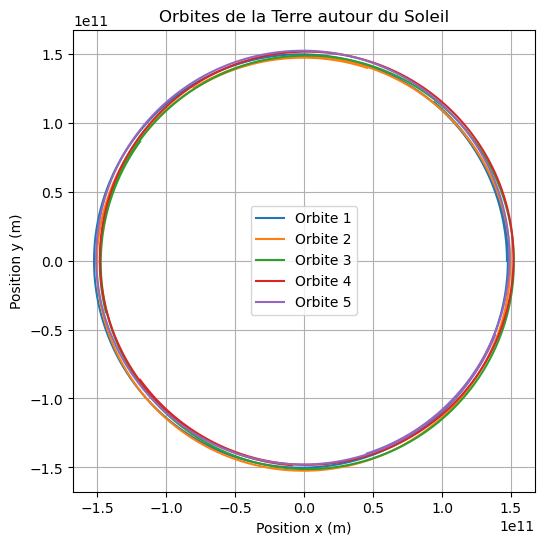

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import constants as const
from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

# Constantes
G = const.G.value  # Constante gravitationnelle
M = const.M_sun.value  # Masse du Soleil
m = const.M_earth.value  # Masse de la Terre

# Paramètres de simulation
dt = 3600  # 1 heure en secondes
steps = 10000  # Nombre de pas de temps

# Conditions initiales au périhélie
r_peri = 1.4710e11
v_peri = 3.0287e4
orbites = 5  # Nombre d'orbites à tracer

# Fonction d'accélération
def acc(r):
    return -G * M * r / np.linalg.norm(r)**3

# Méthode de Verlet
def verlet(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    
    for _ in range(steps):
        k = acc(r)
        r_half = r + 0.5 * v * dt
        v_new = v + k * dt
        r_new = r_half + 0.5 * v_new * dt
        positions.append(r_new)
        r = r_new
        v = v_new
        
    return np.array(positions)

plt.figure(figsize=(8, 6))
for i in range(orbites):
    # Décalage de l'angle initial pour chaque orbite
    theta_shift = 2 * np.pi * i / orbites
    # Conditions initiales pour cette orbite
    r0 = np.array([r_peri * np.cos(theta_shift), r_peri * np.sin(theta_shift)])
    v0 = np.array([-v_peri * np.sin(theta_shift), v_peri * np.cos(theta_shift)])
    orbite = verlet(r0, v0, dt, steps)
    plt.plot(orbite[:, 0], orbite[:, 1], label=f'Orbite {i+1}')

plt.xlabel('Position x (m)')
plt.ylabel('Position y (m)')
plt.title('Orbites de la Terre autour du Soleil')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend()
plt.show()

Figure 1: Comme on peut le voir sur cette figure, à chaque fois que la terre effectue une rotation complète autour du soleil, l'orbite se décale légèrement, mais reste fermée et fortement circulaire.

### b)

Modifiez votre programme pour qu’il calcule aussi l’énergie potentielle $-GMm/r$ et
cinétique $\frac{1}{2}mv^2$ à chaque pas, ainsi que la somme (énergie totale) de ces deux quantitées.
Rapportez ces valeurs en fonction du temps dans un graphique et commentez.

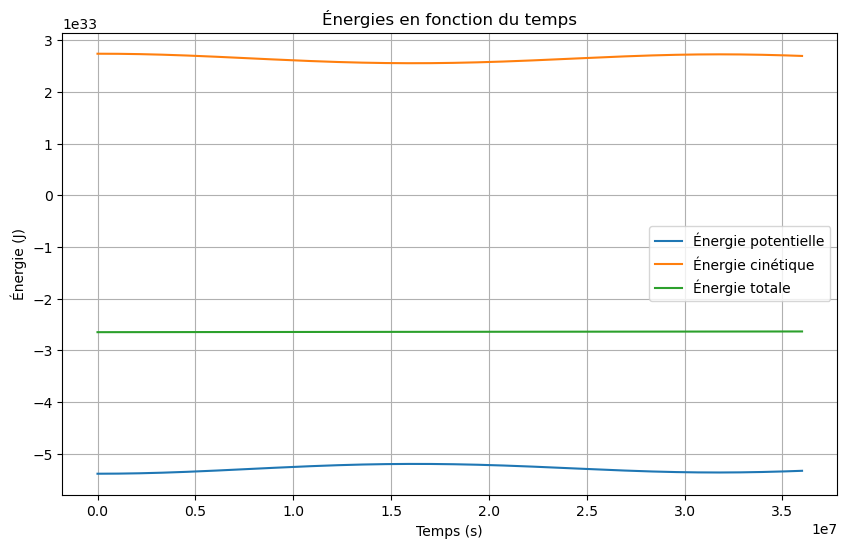

In [2]:
# Calcul de l'énergie potentielle
def U(r):
    return -G * M * m / np.linalg.norm(r)

# Calcul de l'énergie cinétique
def KE(v):
    return 0.5 * m * np.linalg.norm(v)**2

# Calcul de l'énergie totale (somme de l'énergie potentielle et de l'énergie cinétique)
def E(U, KE):
    return U + KE

def verlet(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    Pot = [U(r0)]  
    Cin = [KE(v0)]  
    Energie_tot_Verlet = [E(Pot[0], Cin[0])]  
    
    for _ in range(steps):
        k = acc(r)
        r_half = r + 0.5 * v * dt
        v_new = v + k * dt
        r_new = r_half + 0.5 * v_new * dt
        positions.append(r_new)
        
        # Calcul des énergies à chaque pas de temps et les stocker dans les listes correspondantes
        Pot.append(U(r_new))
        Cin.append(KE(v_new))
        Energie_tot_Verlet.append(E(Pot[-1], Cin[-1]))
        
        r = r_new
        v = v_new
        
    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot_Verlet)

# Appel de la fonction verlet pour obtenir les valeurs des énergies
orbite, Pot, Cin, Energie_tot_Verlet = verlet(r0, v0, dt, steps)

# Plot des énergies en fonction du temps
time_values = np.arange(steps + 1) * dt
plt.figure(figsize=(10, 6))
plt.plot(time_values, Pot, label='Énergie potentielle')
plt.plot(time_values, Cin, label='Énergie cinétique')
plt.plot(time_values, Energie_tot_Verlet, label='Énergie totale')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie (J)')
plt.title('Énergies en fonction du temps')
plt.legend()
plt.grid(True)
plt.show()

Figure 2: Comme on peut le voir sur ce graphique, l'énergie cinétique est positive, l'énergie potentielle est négative et la somme des deux est elle aussi négative et constante. Le fait que cette somme des énergie soit négative et aussi constante nous permet de confirmer que la terre est bel et bien en orbite stable autour du soleil. En effet, une énergie cinétique supérieure à l'énergie potentielle engendrerait la sortie d'orbite de la terre.

### c)

Utilisez maintenant la méthode d’Euler, RK2 et RK4 pour calculer l’orbite de la Terre
et l’énergie totale en fonction du temps, que vous rapportez sur le même graphique que
l’énergie totale en fonction du temps calculée par la méthode de Verlet. Votre graphique
devrait montrer le caractère symplectique de la méthode de Verlet vs Euler/RK2/RK4.

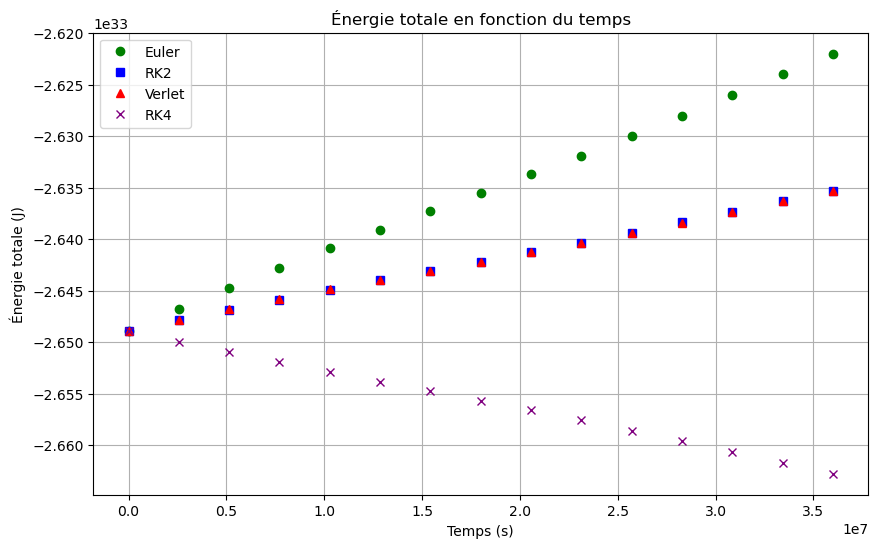

In [3]:
# Définir r0 et v0 pour les méthodes d'Euler, RK2 et RK4
r0 = np.array([r_peri, 0])  # position initiale
v0 = np.array([0, v_peri])  # vitesse initiale

# Méthode d'Euler
def Euler(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    Pot = [U(r0)]
    Cin = [KE(v0)]
    Energie_tot = [E(Pot[0], Cin[0])]
    
    for _ in range(steps):
        k = acc(r)
        r_new = r + v * dt
        v_new = v + k * dt
        
        # Calcul des énergies pour la nouvelle position et vitesse
        Pot_new = U(r_new)
        Cin_new = KE(v_new)
        
        positions.append(r_new)
        Pot.append(Pot_new)
        Cin.append(Cin_new)
        Energie_tot.append(E(Pot_new, Cin_new))
        
        r = r_new
        v = v_new
        
    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot)

# Méthode RK2 (Runge-Kutta d'ordre 2)
def RK2(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    Pot = [U(r0)]
    Cin = [KE(v0)]
    Energie_tot = [E(Pot[0], Cin[0])]
    
    for _ in range(steps):
        k1 = acc(r)
        k2 = acc(r + 0.5 * v * dt)
        r_new = r + v * dt
        v_new = v + k2 * dt
        positions.append(r_new)
        
        # Calcul des énergies et les stocker dans les listes correspondantes
        Pot.append(U(r_new))
        Cin.append(KE(v_new))
        Energie_tot.append(E(Pot[-1], Cin[-1]))
        
        r = r_new
        v = v_new
        
    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot)

# Méthode RK4 (Runge-Kutta d'ordre 4)
def RK4(r0, v0, dt, steps):
    r = r0
    v = v0
    positions = [r0]
    Pot = [U(r0)]
    Cin = [KE(v0)]
    Energie_tot = [E(Pot[0], Cin[0])]
    
    for _ in range(steps):
        k1 = acc(r)
        k2 = acc(r + 0.5 * v * dt)
        k3 = acc(r + 0.5 * v * dt + 0.25 * k2 * dt**2)
        k4 = acc(r + v * dt + 0.5 * k3 * dt**2)
        
        r_new = r + (v + (1/6) * (k1 + 2*k2 + 2*k3 + k4) * dt) * dt
        v_new = v + (1/6) * (k1 + 2*k2 + 2*k3 + k4) * dt
        positions.append(r_new)
        
        # Calcul des énergies et les stocker dans les listes correspondantes
        Pot.append(U(r_new))
        Cin.append(KE(v_new))
        Energie_tot.append(E(Pot[-1], Cin[-1]))
        
        r = r_new
        v = v_new
        
    return np.array(positions), np.array(Pot), np.array(Cin), np.array(Energie_tot)

# Appel des méthodes pour obtenir les valeurs des énergies
orbite_Euler, Pot_Euler, Cin_Euler, Energie_tot_Euler = Euler(r0, v0, dt, steps)
orbite_RK2, Pot_RK2, Cin_RK2, Energie_tot_RK2 = RK2(r0, v0, dt, steps)
orbite_RK4, Pot_RK4, Cin_RK4, Energie_tot_RK4 = RK4(r0, v0, dt, steps)

# Déterminer les indices des points à conserver
indices = np.linspace(0, len(time_values) - 1, 15, dtype=int)

# Plot des énergies en fonction du temps pour toutes les méthodes
plt.figure(figsize=(10, 6))
plt.plot(time_values[indices], Energie_tot_Euler[indices], 'o', color='green', label='Euler')  # Points verts pour Euler
plt.plot(time_values[indices], Energie_tot_RK2[indices], 's', color='blue', label='RK2')  # Carrés bleus pour RK2
plt.plot(time_values[indices], Energie_tot_Verlet[indices], '^', color='red', label='Verlet')  # Triangles rouges pour Verlet
plt.plot(time_values[indices], Energie_tot_RK4[indices], 'x', color='purple', label='RK4')  # Croix violettes pour RK4
plt.xlabel('Temps (s)')
plt.ylabel('Énergie totale (J)')
plt.title('Énergie totale en fonction du temps')
plt.legend()
plt.grid(True)
plt.show()

Figure 3: Comme on peut le voir sur la figure ci-dessus, les énergies totales de chaque méthode varient, mais de façon négligeable. En effet, après plus d'un an, la variation entre les énergies totales de la méthode de Verlet et RK2 sont égales et ne varient que de quelques $10^{30}$ joules par rapport aux autres méthodes, ce qui est relativement petit comparé aux $10^{33}$ joules en jeux (clairement y'a moyen de mieux dire ça XD).

### d)

Utilisez maintenant la méthode de Bulirsch-Stoer pour calculer l’orbite de la Terre,
avec une précision de 1 km par année (voir l’exemple 8.7 dans le Newman pour une
implémentation, que vous pouvez réutiliser). Utilisez un intervalle H de une semaine.
Comparez avec la précision obtenue avec les autres méthodes.

In [4]:
# Méthode de Bulirsch-Stoer avec ajustement des paramètres pour atteindre une précision de 1 km par année
def bulirsch_stoer(r0, v0, dt, t_final, target_precision):
    # Méthode d'ordre maximal
    def bulirsch_stoer_step(h):
        k1 = h * acc(r)
        k2 = h * acc(r + 0.5 * k1)
        k3 = h * acc(r + 0.75 * k2)
        r1 = r + (2/9) * k1 + (1/3) * k2 + (4/9) * k3
        k4 = h * acc(r1)
        k5 = h * acc(r + (7/24) * k1 + (1/4) * k2 + (1/3) * k3 + (1/8) * k4)
        k6 = h * acc(r + (h/2) * (k1 + 3*k4))
        
        # Extrapolation de Richardson
        R = (k5 - (12/5) * k4 + (8/5) * k3 - (12/25) * k2)
        
        # Estimation de l'erreur
        error = np.linalg.norm(R) / dt
        
        # Mise à jour du pas de temps avec ajustement pour atteindre la précision cible
        h_new = h * min(5, max(0.2, 0.9 * (target_precision / error) ** (1/4)))
        
        return r1, h_new
    
    r = r0
    v = v0
    t = 0
    h = dt
    positions = [r0]
    
    while t < t_final:
        # Réaliser un pas
        r, h = bulirsch_stoer_step(h)
        t += h
        positions.append(r)
        
    return np.array(positions)

# Paramètres pour la comparaison
target_precision = 1e3  # 1 km par année
dt_week = 7 * 24 * 3600  # 1 semaine en secondes

# Calcul de l'orbite avec la méthode de Bulirsch-Stoer
orbit_bs = bulirsch_stoer(r0, v0, dt_week, steps * dt_week, target_precision)

# Calcul de l'orbite avec les autres méthodes avec un pas de temps d'une semaine
orbit_euler_week, _, _, _ = Euler(r0, v0, dt_week, steps)
orbit_rk2_week, _, _, _ = RK2(r0, v0, dt_week, steps)
orbit_rk4_week, _, _, _ = RK4(r0, v0, dt_week, steps)
orbit_verlet_week, _, _, _ = verlet(r0, v0, dt_week, steps)

# Calcul de l'erreur pour chaque méthode
error_bs = np.linalg.norm(orbit_bs[-1] - orbit_bs[0])
error_euler_week = np.linalg.norm(orbit_euler_week[-1] - orbit_euler_week[0])
error_rk2_week = np.linalg.norm(orbit_rk2_week[-1] - orbit_rk2_week[0])
error_rk4_week = np.linalg.norm(orbit_rk4_week[-1] - orbit_rk4_week[0])
error_verlet_week = np.linalg.norm(orbit_verlet_week[-1] - orbit_verlet_week[0])

# Affichage des erreurs
print("Erreur avec la méthode de Bulirsch-Stoer: {:.2f} m".format(error_bs))
print("Erreur avec la méthode d'Euler: {:.2f} m".format(error_euler_week))
print("Erreur avec la méthode RK2: {:.2f} m".format(error_rk2_week))
print("Erreur avec la méthode RK4: {:.2f} m".format(error_rk4_week))
print("Erreur avec la méthode de Verlet: {:.2f} m".format(error_verlet_week))

Erreur avec la méthode de Bulirsch-Stoer: 14425869.65 m
Erreur avec la méthode d'Euler: 3069642355266.30 m
Erreur avec la méthode RK2: 1490594195722.48 m
Erreur avec la méthode RK4: 2243941503500775.50 m
Erreur avec la méthode de Verlet: 1844024016139.63 m


## TP3.2 Mécanique céleste - Mars

### e)

Utilisez Bulirsch-Stoer pour calculer la position de Mars 203 jours plus tard, soit le 18
février 2021 (jour de l’atterrissage). Ne lésinez pas sur la précision, ¸ca coûte cher un
astromobile. Notez que les calculs seront effectués en trois dimensions. Comparez votre
position calculée à la valeur de l’éphéméride, soit
eph.position(’mars’,atterissage.jd). Commentez, notamment sur vos limites et
celles de la méthode utilisée, peut-être en vous inspirant d’informations à cette adresse$^1$.

1.https://en.wikipedia.org/wiki/Jet_Propulsion_Laboratory_Development_Ephemeris

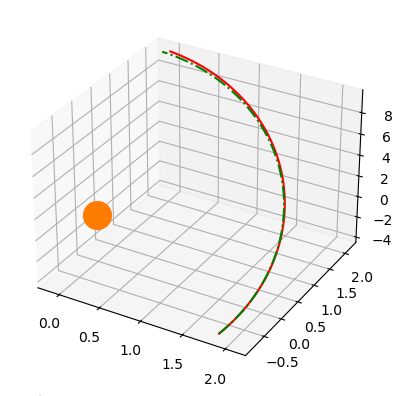

In [5]:
from jplephem import Ephemeris
import matplotlib.pyplot as plt
from astropy import constants
from astropy.time import Time
from numba import njit
import numpy as np
import de421

def return_ephemeris_data():
	x = []
	y = []
	z = []
	t = np.linspace(lancement.jd,atterrissage.jd,10000)
	for i in t:
		position, velocity = eph.position_and_velocity('mars',i)
		x_i,y_i,z_i = position
		x.append(x_i[0])
		y.append(y_i[0])
		z.append(z_i[0])
	return [x,y,z,t]

@njit(fastmath=True, nogil=True)
def bulirsch_stoer(y, t, tf, dt, tol=1e-3, n_steps=4):

	def acceleration(rv):
		r, v = rv[:3], rv[3:]
		a = (-r*G*M_sun)/(np.linalg.norm(r)**3)
		return np.concatenate((v, a))

	solution = [y]
	time_stamp = [t]

	while t < tf:
		H = dt / np.power(2, np.arange(1, n_steps))
		R = np.empty((H.size, y.size))

		ym = y + 0.5 * dt * acceleration(y)
		R2 = y + dt * acceleration(ym)

		for n, h in enumerate(H):
			ym = y + 0.5 * h * acceleration(y)
			R[n] = y + h * acceleration(ym)

			y_new = R2 + (R2 - R[-1]) / (dt / h)**2
			error = np.linalg.norm(y_new - R2)
			if error < tol:
				break

		if error >= tol:
			dt *= 0.5
		else:
			y = y_new
			t += dt
			solution.append(y)
			time_stamp.append(t)
			if error < tol / 10:
				dt *= 1.2

	return solution, time_stamp

# Constante

G = constants.G.value*7.46304 # en km^3/(kg * jour^2)
M_sun = constants.M_sun.value

eph = Ephemeris(de421)
atterrissage = Time("2021-02-18")
lancement = Time("2020-07-30")

# Calcul de la trajectoire 

position, velocity = eph.position_and_velocity('mars',lancement.jd)

r0 = np.asarray((position[0][0], position[1][0], position[2][0]))
v0 = np.asarray((velocity[0][0], velocity[1][0], velocity[2][0]))
y0 = np.concatenate((r0, v0))
tol = 1e4

solution, time_stamp = bulirsch_stoer(y0, lancement.jd, atterrissage.jd, 1, tol, 4)
solution = np.asarray(solution)
x,y,z,t = return_ephemeris_data()

# Pour la comparaison dans la prochaine cellule
time_stamp = time_stamp - lancement.jd
t = t-lancement.jd

ax = plt.figure().add_subplot(projection='3d')
ax.plot(0,0,0,marker=".", markersize=40, color="#FF7C00")
ax.plot(x,y,z, color="r")
ax.plot(solution[:,0],solution[:,1],solution[:,2], linestyle="-.", color="g")
plt.show()

On observe que peu importe la précision que l'on veut obtenir, on n'arrive pas à obtenir la bonne position finale. En effet, ici il y a un problème de modèle et non de méthode de résolution numérique. En effet, on néglige complètement l'effet des autres planète dand notre modèle. Pour obtenir une meilleure précision il faudrait tenir compte du problème entier, soit un problème à n corps.

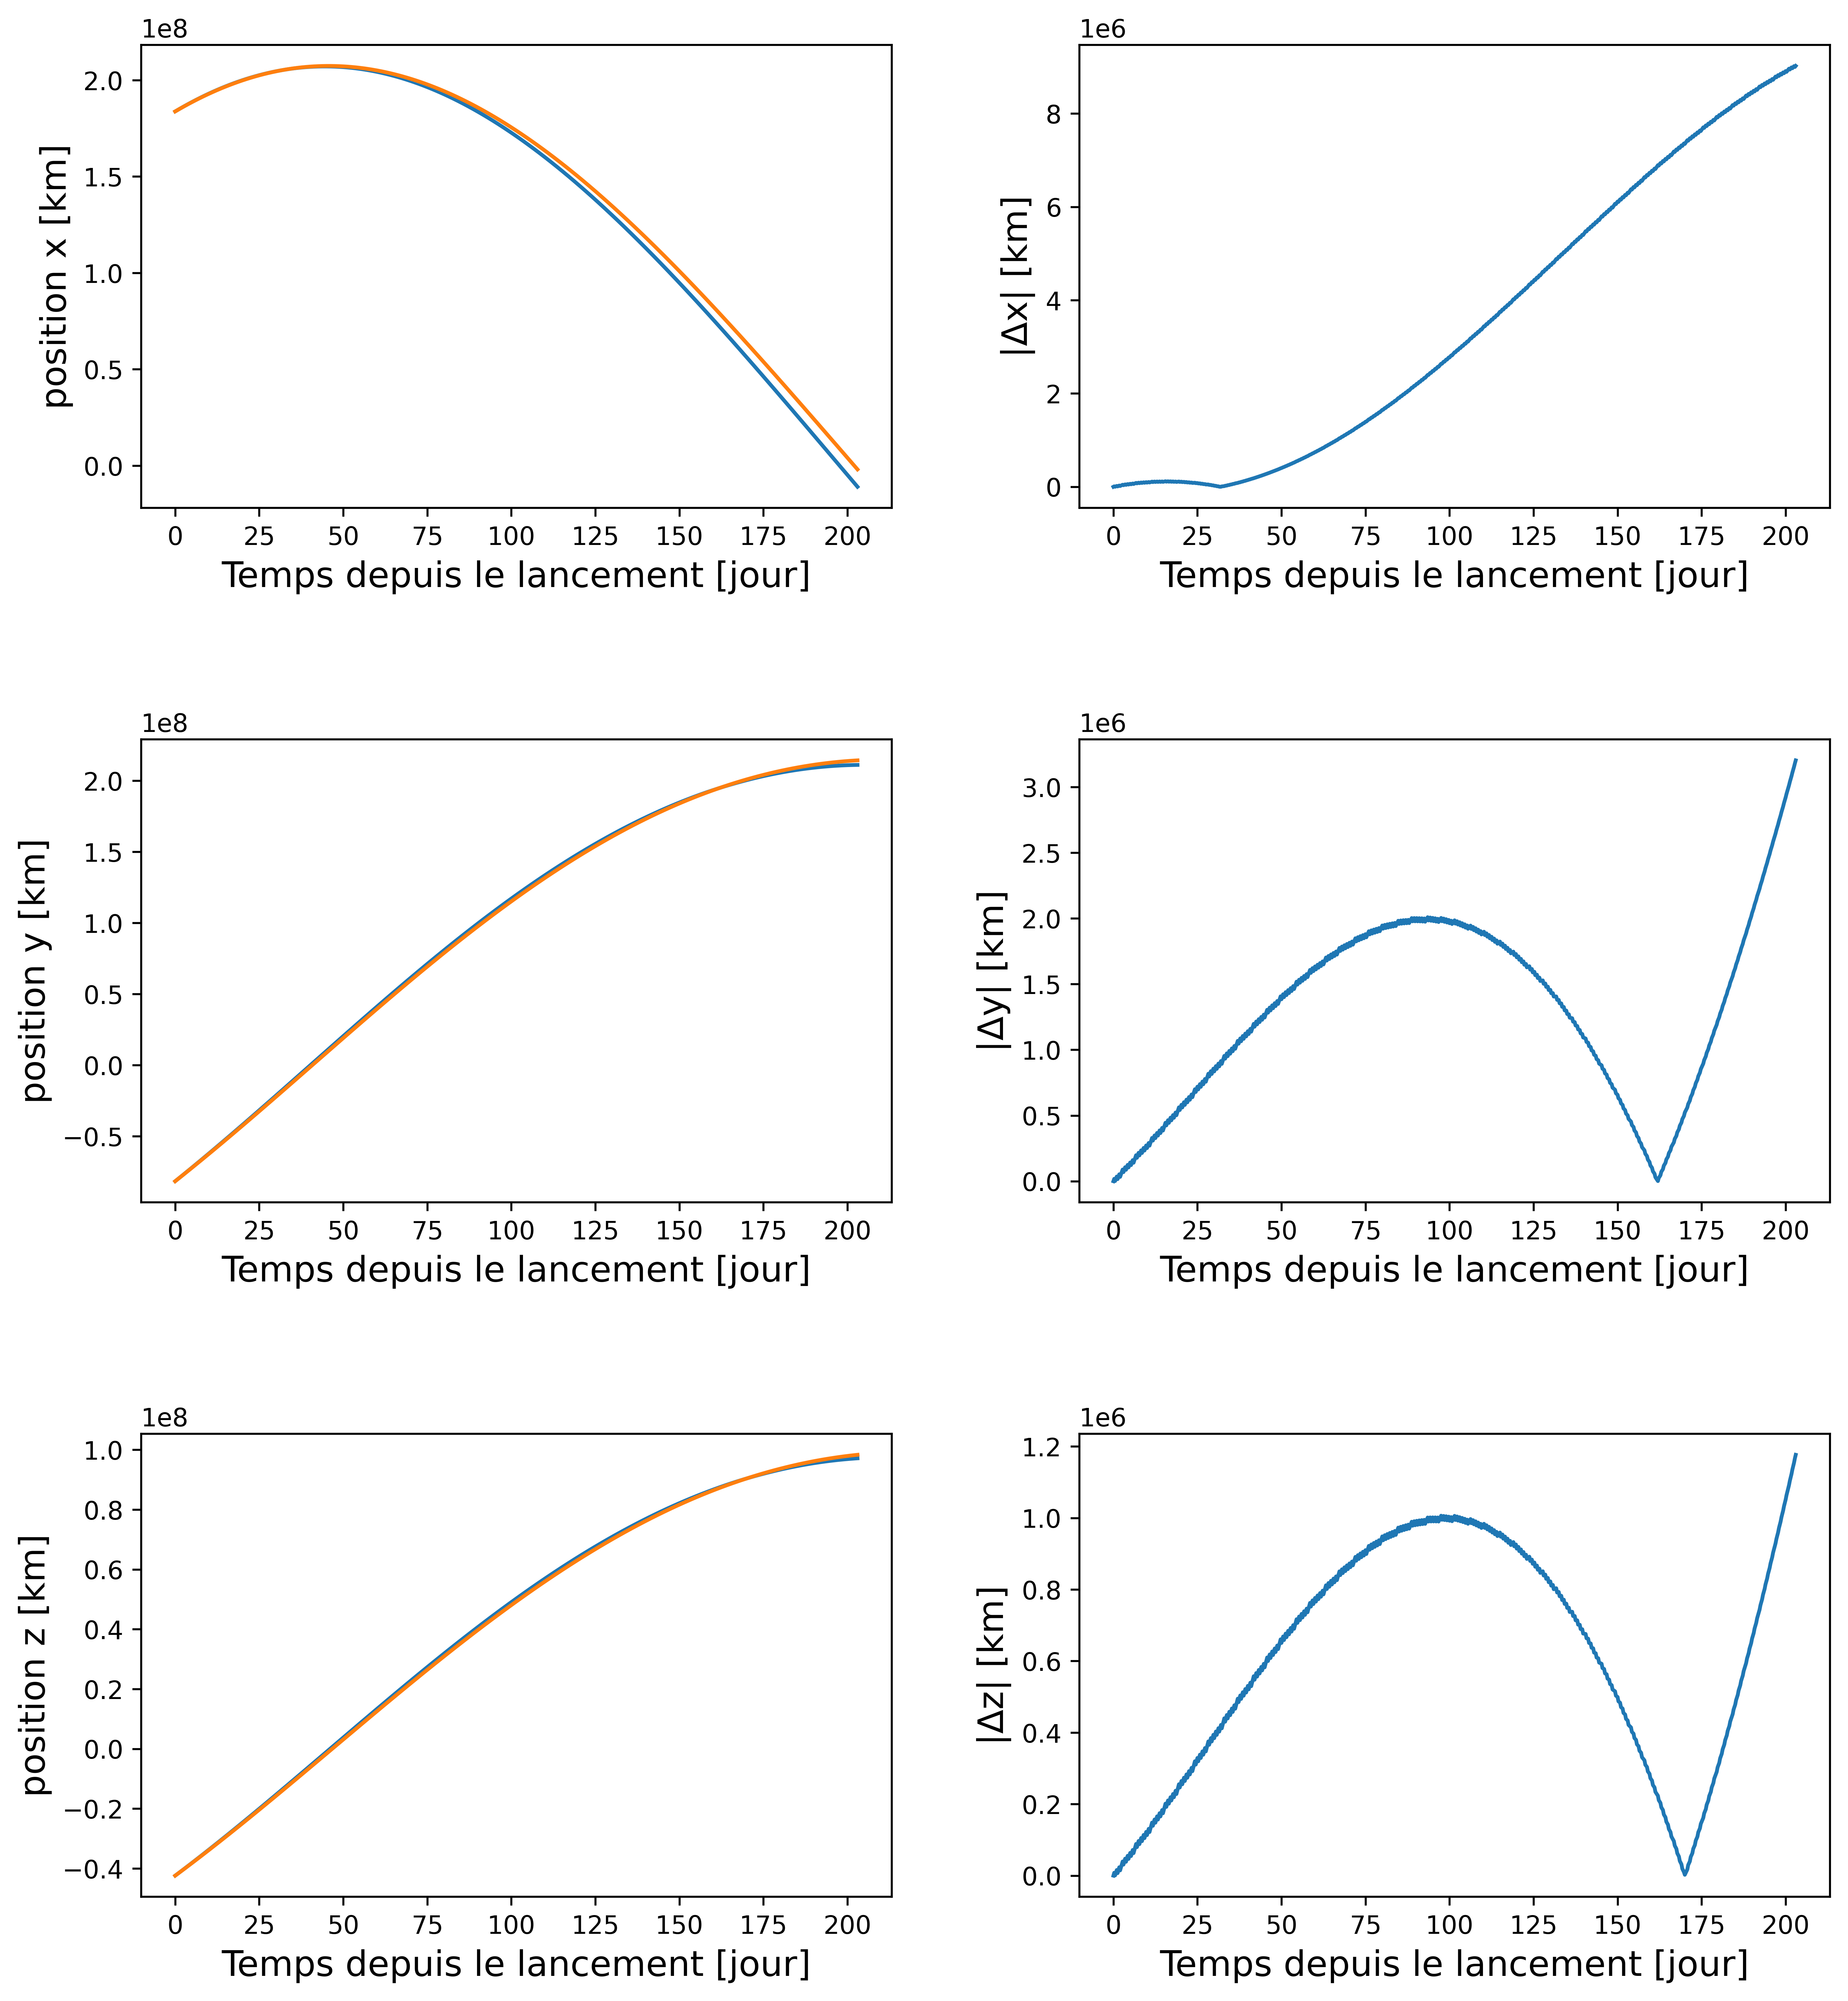

In [6]:
# On veut comparer notre solution avec les données
x_comparaison = []
y_comparaison = []
z_comparaison = []

for i in time_stamp:
	closest_index = np.argmin(np.abs(t - i))
	x_comparaison.append(x[closest_index])
	y_comparaison.append(y[closest_index])
	z_comparaison.append(z[closest_index])

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12), dpi=600)
plt.subplots_adjust(bottom=0, top=0.85, wspace=0.25, hspace=0.5)
ax[0][0].plot(time_stamp,solution[:,0])
ax[0][0].plot(t,x)
ax[0][0].set_xlabel("Temps depuis le lancement [jour]", fontsize=14)
ax[0][0].set_ylabel("position x [km]", fontsize=14)
ax[1][0].plot(time_stamp,solution[:,1])
ax[1][0].plot(t,y)
ax[1][0].set_xlabel("Temps depuis le lancement [jour]", fontsize=14)
ax[1][0].set_ylabel("position y [km]", fontsize=14)
ax[2][0].plot(time_stamp,solution[:,2])
ax[2][0].plot(t,z)
ax[2][0].set_xlabel("Temps depuis le lancement [jour]", fontsize=14)
ax[2][0].set_ylabel("position z [km]", fontsize=14)

ax[0][1].plot(time_stamp,np.abs(solution[:,0]-x_comparaison))
ax[0][1].set_xlabel("Temps depuis le lancement [jour]", fontsize=14)
ax[0][1].set_ylabel("|Δx| [km]", fontsize=14)
ax[1][1].plot(time_stamp,np.abs(solution[:,1]-y_comparaison))
ax[1][1].set_xlabel("Temps depuis le lancement [jour]", fontsize=14)
ax[1][1].set_ylabel("|Δy| [km]", fontsize=14)
ax[2][1].plot(time_stamp,np.abs(solution[:,2]-z_comparaison))
ax[2][1].set_xlabel("Temps depuis le lancement [jour]", fontsize=14)
ax[2][1].set_ylabel("|Δz| [km]", fontsize=14)
plt.show()

### f)

Quelle méthode numérique la NASA utilise-t-elle pour envoyer des sondes vers Mars ?

le transfert de Hohmann? (À vérifier)

### g)

Cette méthode est-elle en cause dans la perte du Mars Climate Orbiter en 1999 ? Si non,
quelle a été la cause de cette perte ?

Non c'était un problème de conversion d'unité (SI et impérial)

## TP3.3 L’´equation de Schrödinger et la méthode spectrale

### h)

Ecrivez un programme pour calculer les valeurs des coefficients $b_k$, qui peuvent de façon
pratique être séparés en composantes réelles et imaginaires $(b_k = α_k + iη_k)$. Divisez la
boîte en N = 1000 tranches et créez deux conteneurs pour les parties rélles et imaginaires
de $\psi(x_n, 0)$ à chaque point de la grille. Effectuez une transformée en sinus pour chaque
conteneur séparément, i.e. calculez les valeurs de $α_k$ et $β_k$ pour k = 1...N − 1. Vous
utiliserez les fonctions du module dcst de Newman (Appendix E ou son site web).

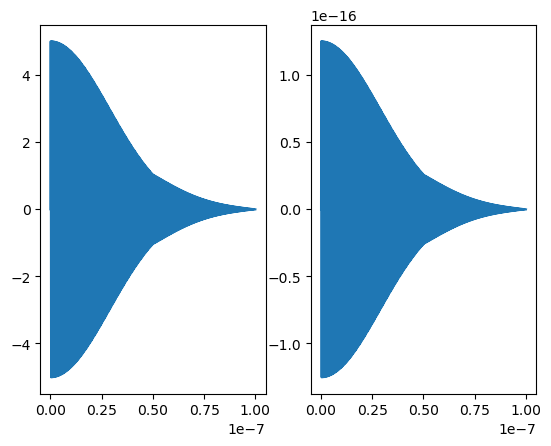

In [7]:
def dst(y): # Fonction de Newmann
    N = len(y)
    y2 = empty(2*N,float)
    y2[0] = y2[N] = 0.0
    y2[1:N] = y[1:]
    y2[:N:-1] = -y[1:]
    a = -imag(rfft(y2))[:N]
    a[0] = 0.0

    return a

M = 9.109e-31
L = 10e-8
x0 = L/2
sigma = 1e-10
kappa = 5e-10
N = 1000
x = np.linspace(0,L,N)

def psi(x):
    return np.exp(-(x-x0)**2/(2*sigma**2))*np.exp(1j*kappa*x)

p = psi(x)
pr = p.real
pi = p.imag

ak = dst(pr)
nk = dst(pi)

fig,ax = plt.subplots(1,2)
ax[0].plot(x, ak)
ax[1].plot(x, nk)
plt.show()



### i)

Expliquez pourquoi Newman s’en remet à la fonction rfft de numpy pour calculer la
transformée en sinus.

### j)

En injectant $b_k = α_k + iη_k$ dans la solution et en prenant la partie réelle, nous obtenons

$Re\psi(x_n, t) = \frac{1}{N}\sum_{k=1}^{N-1} \bigg[ \alpha_k cos \bigg( \frac{\pi^2\hbar k^2}{2ML^2}t \bigg) -\eta_k sin \bigg( \frac{\pi^2\hbar k^2}{2ML^2}t \bigg) \bigg] sin \bigg( \frac{\pi k n}{N} \bigg)$

pour la partie réelle de la fonction d’onde.
Une inspection vous convaincra qu’il s’agit de l’inverse d’une transformée en sinus pour
la quantité entre crochets. Complétez votre programme pour qu’il calcule la partie réelle
de $\psi(x_n, t)$ pour un t arbitraire à l’aide de la fonction idst fournie par Newman. Testez
votre programme en illustrant la fonction d’onde à t = 10−16 s.

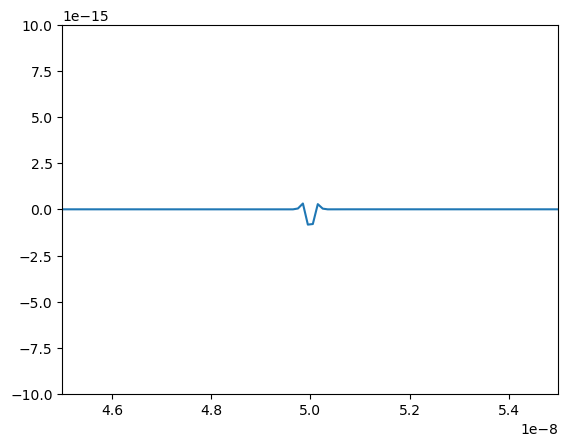

In [8]:
def idst(a): # Fonction de Newmann
    N = len(a)
    c = empty(N+1,complex)
    c[0] = c[N] = 0.0
    c[1:N] = -1j*a[1:]
    y = irfft(c)[:N]
    y[0] = 0.0

    return y

hbar = const.hbar.value
n = x*N/L
k = np.linspace(1,N-1,N)

def crochet(k, t, ak, hbar, M ,L, nk):
    return ak*np.cos((np.pi**2*hbar*k**2)/(2*M*L**2)*t)-nk*np.sin((np.pi**2*hbar*k**2)/(2*M*L**2)*t)



def plot(t):
    psi = np.zeros(N)
    for i in k:
        psi += (crochet(k ,t, ak, hbar, M, L, nk)*np.sin(pi*k*n/N)/N)
    plt.plot(x,psi)
    plt.ylim(-1e-14,1e-14)
    plt.xlim(0.45e-7,0.55e-7)

plot(1e-16)

plt.show()


### k)

Maintenant que tout est en place, vous pouvez produire une animation de l’évolution de
la fonction d’onde (normalisée) au cours du temps, en générant une image à plusieurs t
(utilisez un incrément de 10−18 s). Il y a probablement plusieurs façons d’y arriver, l’une
d’elle étant le package visual. Prenez soin d’ajuster le taux de rafraîchissement et les
échelles pour bien apprécier la dynamique de la fonction d’onde.

In [9]:
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['axes.labelpad'] = 20
plt.ioff()
def init():
    plt.cla()

def animate(i):
    plt.cla()
    plot(i*5e-18)

fig = plt.figure(figsize=(14,7))
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100)
ani

### l)

Laissez tourner votre animation un moment et décrivez ce que vous observez, en utilisant
bien entendu un langage se rapportant à la physique du problème.